# Hopefield model with generated patterns

The Hopefield model is a model of neuron dynamics, in this project we mapped our network in a spin system with inhomogeneous couplings. The full Hamiltonian of the system is $H[S] = - \sum_{i<j} J_{ij}S_iS_j$. The network in practice is used to store patterns, a pattern $x^i = \{S_j\}_{j=1,...N}$ is a given configuration of the system, with $S_j = \pm 1$.

The aim of this part of the project is to show that the network can store $P$ different patterns and, furthermore, given a corrupted pattern $y^a$ (i.e. a pattern $y^a_i = x^a_i$ with probability $q<1$, otherwise $y^a_i = -x^a_i$ with probability $1-q$) it can reconstruct the original pattern $x^a$ with energy minimization of that system.

That minimization is implemented using the iterating sign rule: each spin at iteration $t+1$ is: 


$$
\begin{cases}
S_i(t+1) = \sum_j J_{ij}S_j(t) \\
S(0)=y^a
\end{cases}
$$



In [1]:
import numpy as np
from numpy import random
from matplotlib import pyplot as plt
from scipy import optimize
from scipy import interpolate
%config InlineBackend.figure_format = 'svg' 

The couplings matrix is:

$$
J_{ij} = \frac{1}{N}\sum_{a=1}^P x_j^a x_i^a 
$$
This matrix represents the coupling interaction between all the spins, using the Hebb rule (neglecting the self interaction):

$$
J_{ii} = 0
$$

In [2]:
def J(M):
    
    matrix_dim = M.shape
    J          = np.zeros((matrix_dim[1],matrix_dim[1]))

    for i in range(0,matrix_dim[1]):
        for j in range(0,matrix_dim[1]):
            if j!=i:
                J[i,j] = np.sum([M[a,i]*M[a,j] for a in range(0,matrix_dim[0])])/matrix_dim[1]
    return J

The input of our model is a set of randomly generated arrays containing $+1$ and $-1$, stored in a $P \times N$ matrix $M$.

In [3]:
def create_M(P,N):
    import numpy as np
    M = np.zeros((P,N))
    k = 0
    
    for i in range(0,P):
        k = 0
        while True:
            k = 0
            M[i] = np.random.choice([-1,1],size=N)
            for j in range(0,i): 
                if (M[i]==M[j]).all()==True:
                    k += 1 
            if k==0:
                break        
    return M


In [4]:
def Wrong_patterns(q,M):

    Y = np.zeros((M.shape))

    for i in range(0,M.shape[0]):
        x = M[i,:]
        for j in range(0,M.shape[1]):
            rand = np.random.random_sample()
            if rand<=q:
                Y[i,j] = x[j] 
            else:
                Y[i,j] = -x[j]
    return Y

In [5]:
def Update_y(J,y,M,iter_max=100):
    import numpy as np
    flag = 1
    t    = 0 
    
                                                # Update
    y_old    = np.zeros(len(y))
    y_old[:] = y[:]
    while flag and t <= iter_max :
        for i in range(J.shape[1]):
            y[i] = np.sign(np.dot(J[i,:],y)) 
            if y[i]==0:                      #y_i = 0 --> np.sign(0) = 0 --> we put y_i = 1
                y[i] = 1
        t += 1
        k  = 0
        for j in range(0,len(y)):
            if(y[j] == y_old[j]):
                k += 1
        if k==len(y):
            flag = 0
        else:
            y_old[:] = y[:]
                
                                                # Pattern of y updated
    P_a = -1
    if flag == 0:
        for i in range(M.shape[0]):
            k = 0
            for j in range(0,len(y)):
                if(y[j] == M[i,j]):
                    k += 1
            if k == len(y):
                P_a = i
    return P_a,t


# Statistics on the patterns

In this cell we cycle over the number of patterns (incrementing it), with the number of spins fixed ($N=100$). We created the matrices $M$ and $J$, and we increased the probability $q$ with different length steps. 

In [6]:
def mov_avg(x, w):
    x_n = np.zeros(len(x))
    for m in range(len(x)-(w-1)):
        x_n[m] = sum(np.ones(w) * x[m:m+w]) / w 
    return x_n

Number of pattern:5


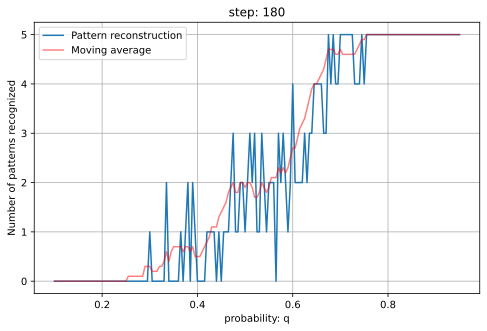

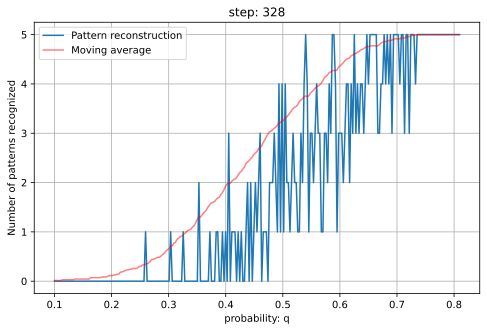

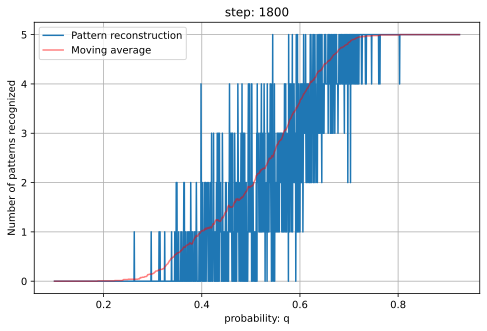

Number of pattern:10


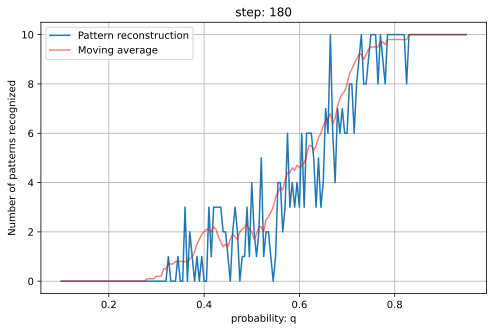

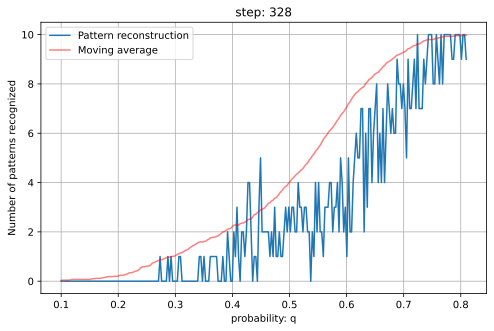

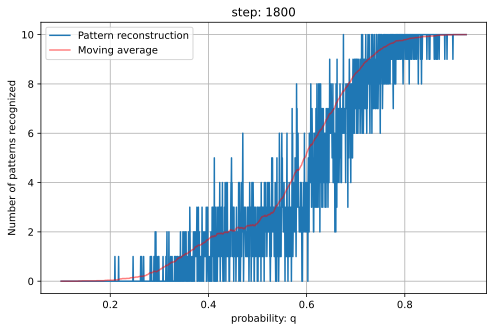

Number of pattern:25


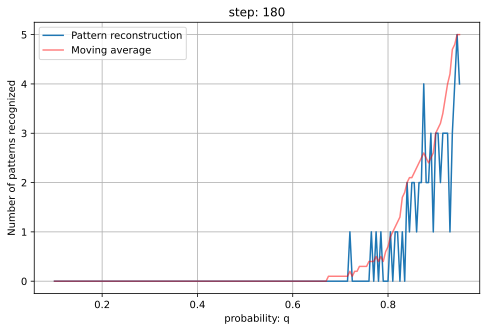

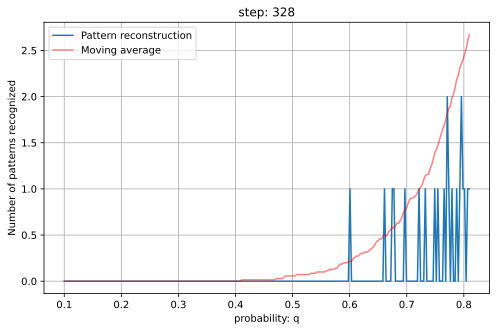

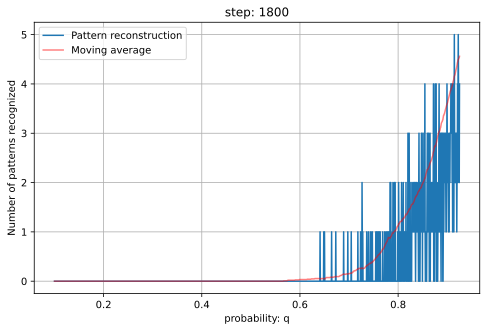

In [8]:
P = [5,10,25] #number of patterns
N = 100       #number of spins per patterns


for l in P:
    M = create_M(l,N)
    M = np.array(M,dtype=np.float64)
    print("Number of pattern:%d"%l)
    J_matrix=J(M)
    step = [0.005, 0.00275, 0.0005]
    for m in step:
        plt.figure(figsize=(8,5))

        q_list     = np.arange(0.1,1,m)  
        dummy_list = []
        for i in range(0,len(q_list)):

            correct = 0
            Y_1     = Wrong_patterns(q_list[i],M)

            for j in range(0,l):
                pattern_correct, _ = Update_y(J_matrix,Y_1[j],M) 
                if pattern_correct==-1:
                    pass
                else:
                    correct += 1           
            dummy_list.append(correct)
        if m==step[0]:
            avg = mov_avg(dummy_list,10)
            plt.plot(q_list[:-9],dummy_list[:-9],label ='Pattern reconstruction')
            plt.ylabel('Number of patterns recognized')
            plt.xlabel('probability: q')
            plt.title("step: %d"%len(q_list))
            plt.plot(q_list[:-9],avg[:-9], label = "Moving average", c = "r", alpha = 0.5 )
            plt.legend()
            plt.grid()
            plt.show()
        elif m==step[1]:
            avg = mov_avg(dummy_list,70)
            plt.plot(q_list[:-69],dummy_list[:-69],label ='Pattern reconstruction')
            plt.ylabel('Number of patterns recognized')
            plt.xlabel('probability: q')
            plt.title("step: %d"%len(q_list))
            plt.plot(q_list[:-69],avg[:-69], label = "Moving average", c = "r", alpha = 0.5)
            plt.legend()
            plt.grid()
            plt.show()
        elif m==step[2]:
            avg = mov_avg(dummy_list,150)
            plt.plot(q_list[:-149],dummy_list[:-149],label = 'Pattern reconstruction')
            plt.ylabel('Number of patterns recognized')
            plt.xlabel('probability: q')
            plt.title("step: %d"%len(q_list))
            plt.plot(q_list[:-149],avg[:-149], label = "Moving average", c = "r", alpha = 0.5)
            plt.legend()
            plt.grid()
            plt.show()

We can see that for 5 and 10 patterns the model can barely recognize all the patterns for $q> 0.6$ with 5 patterns, while an accuracy of $q>0.7$ is needed for 10 patterns.

The model, indeed, doesn't work if the number of patterns increases. We can see this in the case of 25 patterns where with an accuracy of $99,95\%$ we can't recover more than 3 patterns. So we can say that this model doesn't work where the number of patterns is comparable with the number of spins. 

The red line in the plots is the moving average of the number of  recognized patterns, we used it because the data are really oscillating in the short term. We can see that, increasing the number of steps, the number of recognized patterns tends to saturate at the maximum number of patterns.